In [1]:
import re

import numpy as np
import psycopg2

from psycopg2.extras import RealDictCursor


def select(sql):
    conn = psycopg2.connect("dbname=data user=postgres password=root host=172.23.0.2")
    cur = conn.cursor(cursor_factory=RealDictCursor)
    cur.execute(sql)
    result = cur.fetchall()
    cur.close()
    conn.close()
    return result

In [2]:
hoaxs_name_list = ['Deep State',
                   'Qanon',
                   'New world order',
                   'GLobal Warming is HOAX',
                   'climatechangehoax', 'globalwarminghoax',
                   'COVID19 and microchipping',
                   'COVID19 is preaded by 5G',
                   'Chemtrails',
                   'FlatEarth',
                   'Moon landing is fake',
                   'Illuminati',
                   'Pizzagate conspiracy theory',
                   '9/11 was inside job',
                   'Reptilian conspiracy theory'
                   ]

hoax_list = list(map(lambda x: [x['id'], x['hoax_name']], select('select id, hoax_name from hoaxs')))
# 2017-06-02 22:21:26.000000 +00:00

In [3]:
import pandas as pd
import copy


def create_empty_table(year_count, year_from=2017):
    time = []
    nan = []
    for year in range(year_count):
        for week in range(53):
            time.append(f'{week}/{year + year_from}')
            nan.append(0)

    return [time, copy.deepcopy(nan), copy.deepcopy(nan), copy.deepcopy(nan)]



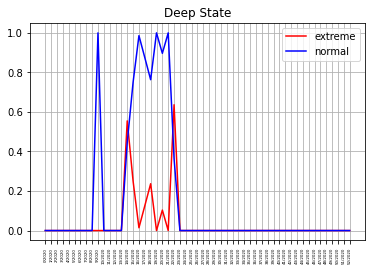

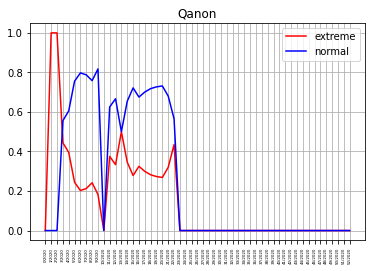

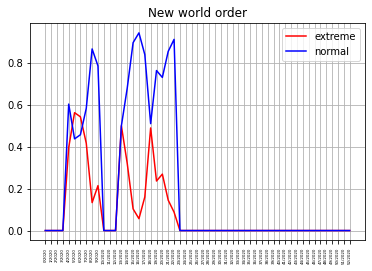

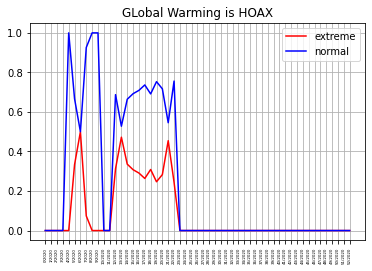

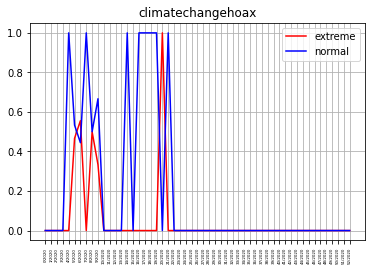

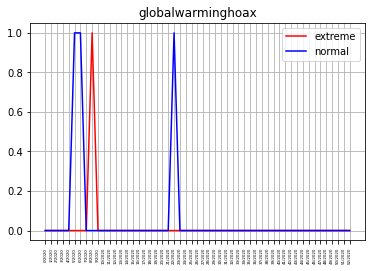

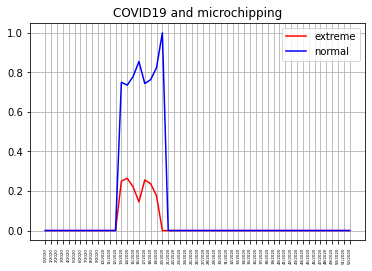

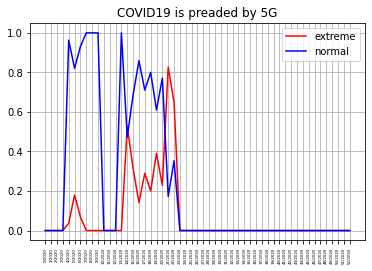

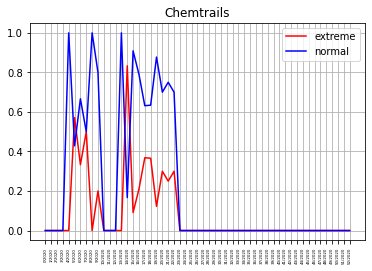

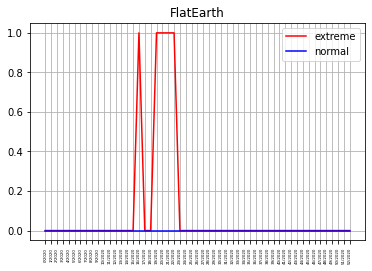

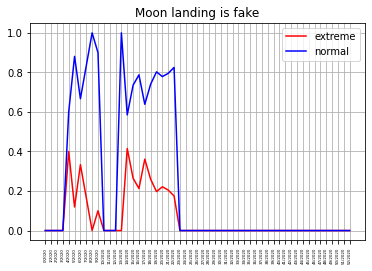

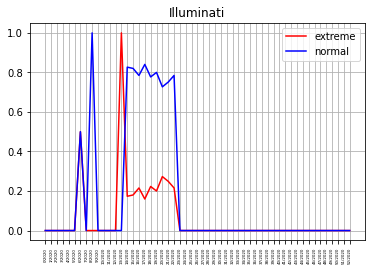

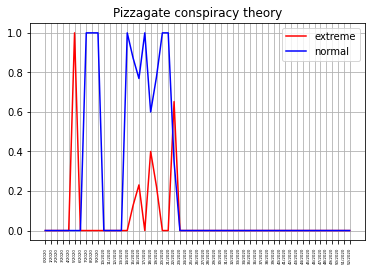

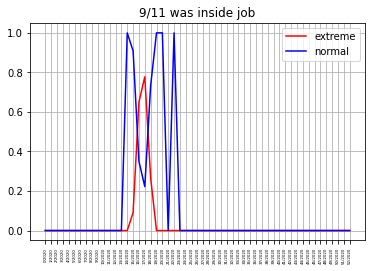

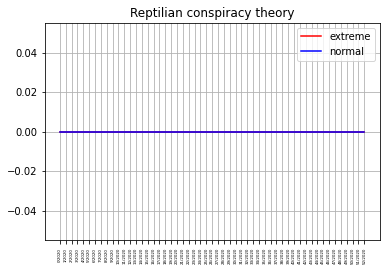

In [57]:
rows = select(
    '''
select DATE_PART('week', t.happened_at) AS Week,
DATE_PART('year', t.happened_at) AS Year,
th.hoax_id,
count(*) as extreme,
null as normal

FROM tweet_hoaxs th join tweets t on t.id = th.tweet_id
WHERE t.compound > 0.5 OR t.compound < -0.5
GROUP BY hoax_id ,Week, Year

union

select DATE_PART('week', t.happened_at) AS Week,
DATE_PART('year', t.happened_at) AS Year,
th.hoax_id,
null as extreme,
count(*) as normal


FROM tweet_hoaxs th join tweets t on t.id = th.tweet_id
WHERE t.compound <= 0.5 and t.compound >= -0.5
GROUP BY hoax_id, Week, Year
ORDER BY hoax_id ,Year, Week;
''')


def _create_data_frame(collections):
    dataframes = []
    for i in range(len(hoaxs_name_list)):
        coll = collections[i]
        data = {'week/year': coll[0], 'extreme': coll[1], 'normal': coll[2], 'total': coll[3]}
        dataframes.append(pd.DataFrame(data))
    return dataframes


def process_data(years_count, years_offset=2017):
    empty_data = create_empty_table(years_count, years_offset)

    collection = []
    for i in range(len(hoaxs_name_list)):
        collection.append(copy.deepcopy(empty_data))

    for row in rows:
        data = collection[row["hoax_id"]]
        try:
            index = data[0].index(f'{int(row["week"])}/{int(row["year"])}')
        except ValueError:
            continue

        if row['normal']:
            data[2][index] = row['normal']
            data[3][index] += row['normal']
        else:
            data[1][index] = row['extreme']
            data[3][index] += row['extreme']
    return _create_data_frame(collection)


from matplotlib import pyplot as plt
import re

path = './result/'
prefix = '2020/'
def f(x, colum_name):
    if x['total'] == 0:
        return float(0)
    else:
        return x[colum_name] / x['total']

import numpy as np


for id, df in enumerate(process_data(1, 2020)):
    file_name = re.sub('/', '_', hoaxs_name_list[id])
    df.to_csv(f'{path + prefix}{file_name}.csv')

    plt.plot(df['week/year'],df.apply(lambda x: f(x,'extreme'), axis=1), color='red', label='extreme')
    plt.plot(df['week/year'],df.apply(lambda x: f(x,'normal'), axis=1), color='blue', label='normal')
    plt.legend()
    # plt.xticks(np.arange(0, len(df['week/year'])+1, step=5/(len(df['week/year'])/62)),size=6, rotation=90)
    plt.xticks(size=4, rotation=90)
    plt.title(hoaxs_name_list[id])
    # plt.figure(figsize=(10,10))
    plt.grid()
    plt.savefig(f'{path + prefix}{file_name}.png',dpi=300)
    plt.show()